##Fruit and Vegetable Classification
##Convolutional Neural Network

In [3]:
#Importing all the important libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import os
from google.colab import drive # if using Google Colab
import os
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
# mount the Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_dir = '/content/drive/MyDrive/PRML/train'
test_dir = '/content/drive/MyDrive/PRML/test '
val_dir = '/content/drive/MyDrive/PRML/validation'

# Function to get file paths and labels from a directory
def get_filepaths_and_labels(directory):
    filepaths = []
    labels = []
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            filepaths.append(file_path)
            labels.append(class_name)
    return filepaths, labels

# Get file paths and labels for train, test, and validation sets
train_filepaths, train_labels = get_filepaths_and_labels(train_dir)
test_filepaths, test_labels = get_filepaths_and_labels(test_dir)
val_filepaths, val_labels = get_filepaths_and_labels(val_dir)

# Function to create a dataframe from file paths and labels
def create_dataframe(filepaths, labels):
    df = pd.DataFrame({'Filepath': filepaths, 'Label': labels})
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    return df

# Create dataframes for train, test, and validation sets
train_df = create_dataframe(train_filepaths, train_labels)
test_df = create_dataframe(test_filepaths, test_labels)
val_df = create_dataframe(val_filepaths, val_labels)


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create an instance of the ImageDataGenerator class
datagen = ImageDataGenerator(rescale=1./255)

# set the target size for the images
img_height, img_width = 224, 224

# use the flow_from_directory method to load the dataset
train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='categorical')

# get the class labels
class_labels = list(train_generator.class_indices.keys())

# print the class labels and the number of images in each class
print("Class labels:", class_labels)
for i, label in enumerate(class_labels):
    print("Class {}: {} images".format(label, train_generator.classes.tolist().count(i)))


Found 3131 images belonging to 36 classes.
Class labels: ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']
Class apple: 68 images
Class banana: 75 images
Class beetroot: 88 images
Class bell pepper: 90 images
Class cabbage: 92 images
Class capsicum: 89 images
Class carrot: 82 images
Class cauliflower: 79 images
Class chilli pepper: 87 images
Class corn: 87 images
Class cucumber: 94 images
Class eggplant: 84 images
Class garlic: 92 images
Class ginger: 68 images
Class grapes: 100 images
Class jalepeno: 92 images
Class kiwi: 89 images
Class lemon: 82 images
Class lettuce: 97 images
Class mango: 86 images
Class onion: 94 images
Class orange:

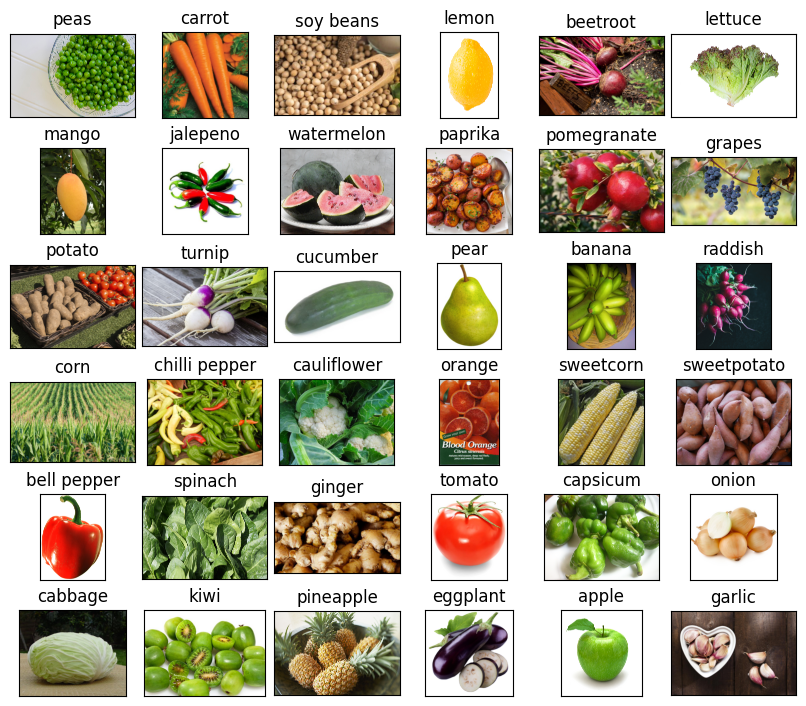

In [7]:
# Create an empty DataFrame to store unique labels
df_unique = pd.DataFrame(columns=['Filepath', 'Label'])

# Loop through each file path and extract the label
for fp in train_df.Filepath:
    label = train_df[train_df.Filepath == fp].Label.iloc[0]

    # Check if the label is already in df_unique
    if label not in df_unique.Label.values:

        # Append the file path and label to df_unique
        df_temp = pd.DataFrame({'Filepath': [fp], 'Label': [label]})
        df_unique = pd.concat([df_unique, df_temp], ignore_index=True)

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize=12)
plt.tight_layout(pad=0.5)
plt.show()

In [8]:
# Load training, test, and validation datasets from directories
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir, seed=2509, image_size=(224, 224), batch_size=32)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_dir, seed=2509, image_size=(224, 224), batch_size=32)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(val_dir, seed=2509, image_size=(224, 224), batch_size=32)

Found 3131 files belonging to 36 classes.
Found 359 files belonging to 36 classes.
Found 351 files belonging to 36 classes.


In [9]:
# Define the data generators for training and testing
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [10]:
# Load the training data from the directory and set up the generator
train_ds = train_datagen.flow_from_directory(
    directory= train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    seed=0
)

# Load the validation data from the directory and set up the generator
val_ds = train_datagen.flow_from_directory(
    directory= val_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    seed=0
)

# Load the testing data from the directory and set up the generator
test_ds = test_datagen.flow_from_directory(
    directory= test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 3131 images belonging to 36 classes.
Found 351 images belonging to 36 classes.
Found 359 images belonging to 36 classes.


In [11]:
# Define the MobileNetV2 model with pre-trained weights from ImageNet
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)


In [12]:
# Set the pretrained model and freeze its layers
pretrained_model.trainable = False

# Define the input layer and pass it through the pretrained model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = pretrained_model(inputs)

# Add a couple of fully connected layers with ReLU activation
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Define the output layer with a softmax activation for multiclass classification
outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

# Create the final model by defining the input and output layers
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with early stopping callback to prevent overfitting
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)


Epoch 1/5
 1/98 [..............................] - ETA: 25:02 - loss: 3.8179 - accuracy: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


98/98 [==============================] - 1089s 11s/step - loss: 1.8586 - accuracy: 0.5113 - val_loss: 0.6201 - val_accuracy: 0.8006
Epoch 2/5
98/98 [==============================] - 410s 4s/step - loss: 0.7906 - accuracy: 0.7531 - val_loss: 0.4492 - val_accuracy: 0.8718
Epoch 3/5
98/98 [==============================] - 384s 4s/step - loss: 0.5908 - accuracy: 0.8068 - val_loss: 0.3688 - val_accuracy: 0.8803
Epoch 4/5
98/98 [==============================] - 419s 4s/step - loss: 0.4670 - accuracy: 0.8470 - val_loss: 0.3263 - val_accuracy: 0.9060
Epoch 5/5
98/98 [==============================] - 411s 4s/step - loss: 0.4190 - accuracy: 0.8534 - val_loss: 0.3587 - val_accuracy: 0.9060


In [13]:
#Saving the model
model.save('/content/drive/MyDrive/PRML/model')

In [14]:
#loading the saved model
from tensorflow import keras

saved_model = keras.models.load_model('/content/drive/MyDrive/PRML/model')

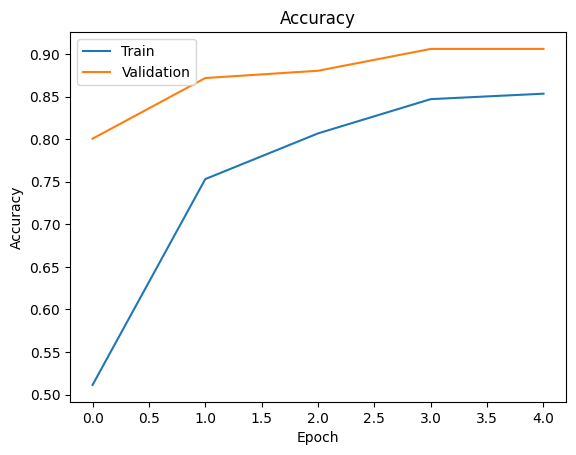

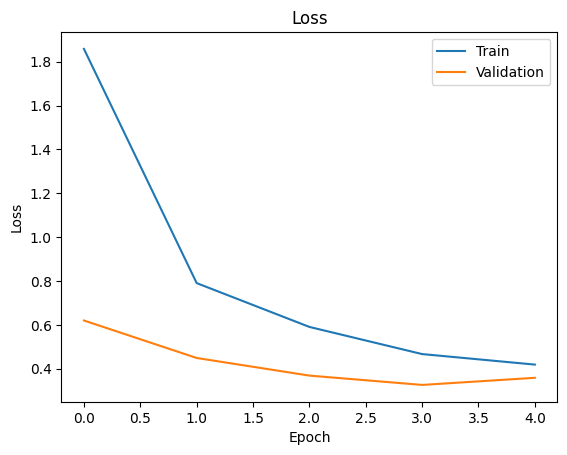

In [15]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


1/1 [==============================] - 2s 2s/step


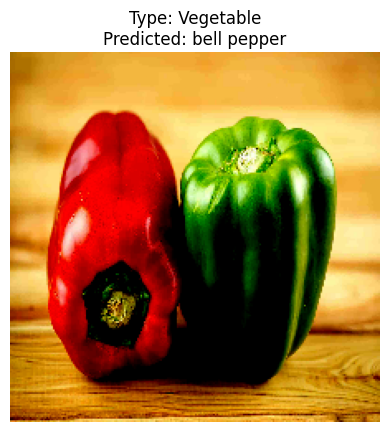

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Select a random image from test images
index = np.random.randint(len(test_ds))
image = test_ds[index][0][0]

# Predict the label of the selected image
pred = saved_model.predict(np.expand_dims(image, axis=0))[0]
pred_label = np.argmax(pred)

# Map the label
labels = test_ds.class_indices
labels = {v: k for k, v in labels.items()}
pred_label = labels[pred_label]

fruits = ['apple', 'banana', 'grapes (1)', 'kiwi (1)',  'mango (1)', 'orange (1)','pear (1)','pineapple (1)', 'pomegranate (1)', 'watermelon (1)', 'tomato (1)' ]

if pred_label in fruits:
  fr_vg = "Fruit"

else:
  fr_vg = "Vegetable"

# Plot the selected image with the actual and predicted labels
plt.imshow(image)
plt.title(f"Type: {fr_vg}\nPredicted: {pred_label}")
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 73ms/step


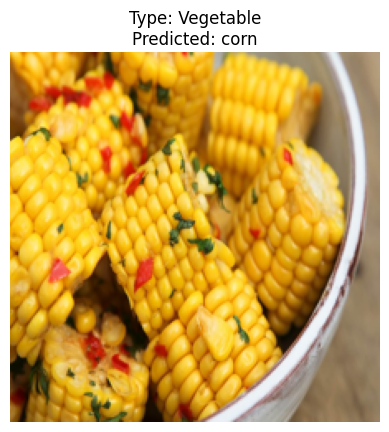

In [17]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the image and resize it to (224, 224)
img_path = '/content/drive/MyDrive/PRML Project/corn.jpg'
img = Image.open(img_path)
img = img.resize((224, 224))

# Convert the image to a numpy array and preprocess it
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

# Expand the dimensions of the image to match the expected input shape of the model
img_array = np.expand_dims(img_array, axis=0)

# Make predictions with the model
preds = saved_model.predict(img_array)

# Get the predicted class label
predicted_label = labels[np.argmax(preds)]

fruits = ['apple', 'banana', 'grapes', 'kiwi',  'mango', 'orange','pear','pineapple', 'pomegranate', 'watermelon', 'tomato' ]

if predicted_label in fruits:
  ty = "Fruit"

else:
  ty = "Vegetable"

# Plot the image with the predicted and actual labels
plt.imshow(img)
plt.title(f"Type: {ty}\nPredicted: {predicted_label}")
plt.axis('off')
plt.show()
